In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

# Задача 1. Изчисления в невронна мрежа

## 1.1. Изчисляване на прав ход в мрежа

In [13]:
linear1 = nn.Linear(2, 2)
act_fn1 = nn.Sigmoid()
linear2 = nn.Linear(2, 2)
act_fn2 = nn.Sigmoid()

x = torch.tensor([1.0, 1.0], requires_grad=False)

W1 = torch.tensor([
    [0.5, 0.3],  # h1
    [0.7, -0.7]  # h2
], dtype=torch.float32)

W2 = torch.tensor([
    [0.3, 0.7],  # y1
    [0.4, 0.5]   # y2
], dtype=torch.float32)


with torch.no_grad():
    linear1.weight.copy_(W1)
    linear1.bias.zero_()
    linear2.weight.copy_(W2)
    linear2.bias.zero_()


z1 = linear1(x)
h = act_fn1(z1)
z2 = linear2(h)
y = act_fn2(z2)


print("Междинни стойности z1(1) и z2(1):", z1.detach().numpy())
print("Активационни стойности:  h1 и h2:", h.detach().numpy())
print("Междинни стойности z1(2) и z2(2):", z2.detach().numpy())
print("Изходни стойности y1 и y2:", y.detach().numpy())

Междинни стойности z1(1) и z2(1): [0.8 0. ]
Активационни стойности:  h1 и h2: [0.6899745 0.5      ]
Междинни стойности z1(2) и z2(2): [0.55699235 0.5259898 ]
Изходни стойности y1 и y2: [0.6357564 0.6285473]


## 1.2. Изчисляване на частната производна на загубата спрямо тегло $\frac{\partial w_{11}^{(2)}}{\partial L}$


In [14]:
target = torch.tensor([0.5, 0.5], dtype=torch.float32)

loss = nn.MSELoss()
L = loss(y, target)

L.backward()

linear2.weight.grad

print("Градиент dL/dw11(2):", linear2.weight.grad[0, 0].item())

Градиент dL/dw11(2): 0.021690819412469864


# Задача 2. Невронна мрежа, обучена с данни от изображения

## 2.1. Структуриране на директории и поддиректории

Създаване директории

In [15]:
import os
import glob

data_dir = "data"

#create training dir
training_dir = os.path.join(data_dir,"train")
if not os.path.isdir(training_dir):
  os.mkdir(training_dir)

#create dog in training
dog_training_dir = os.path.join(training_dir,"dog")
if not os.path.isdir(dog_training_dir):
  os.mkdir(dog_training_dir)

#create cat in training
cat_training_dir = os.path.join(training_dir,"cat")
if not os.path.isdir(cat_training_dir):
  os.mkdir(cat_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

#create dog in validation
dog_validation_dir = os.path.join(validation_dir,"dog")
if not os.path.isdir(dog_validation_dir):
  os.mkdir(dog_validation_dir)

#create cat in validation
cat_validation_dir = os.path.join(validation_dir,"cat")
if not os.path.isdir(cat_validation_dir):
  os.mkdir(cat_validation_dir)

Разпределяне на снимките

In [16]:
import shutil

split_size = 0.8

cat_images = glob.glob("data/train/cat*")
dog_images = glob.glob("data/train/dog*")

cat_images.sort()
dog_images.sort()

for i, img in enumerate(cat_images):
    if i < int(len(cat_images) * split_size):
        shutil.move(img, cat_training_dir)
    else:
        shutil.move(img, cat_validation_dir)

for i, img in enumerate(dog_images):
    if i < int(len(dog_images) * split_size):
        shutil.move(img, dog_training_dir)
    else:
        shutil.move(img, dog_validation_dir)


In [17]:

train_dir = "data/train"
validation_dir = "data/validation"
test_dir = "data/test"

#transformations
transform_pipeline = transforms.Compose([transforms.Resize((64,64)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])

batch_size = 500

#datasets
train_data = datasets.ImageFolder(train_dir,transform=transform_pipeline)
validation_data = datasets.ImageFolder(validation_dir,transform=transform_pipeline)
#test_data = datasets.ImageFolder(test_dir,transform=transforms)

#dataloader
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_data, shuffle = True, batch_size=batch_size)
#test_loader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=batch_size)

## 2.3. Създаване на невронна мрежа

### 2.3.1. Инициализация

    Слой 1 - Това е първият напълно свързан слой (fully connected). Той взима входен вектор с дължина 12288 (това идва от преобразуване на изображение 64×64 с 3 канала: 64×64×3 = 12288). Изходът на слоя е вектор от 84 елемента.

    Слой 2 - Напълно свързан слой. Вход: 84, изход: 50.

    Слой 3 - Изходът е вектор с 2 стойности – по една за всеки от двата класа (напр. котка и куче).

### 2.3.2. Forward pass - как данните преминават през мрежата

    - Оформяне на изображението (view) в 1D вектор (flatten). -1 означава: „автоматично избери броя на примерите (batch size)“. Например: при batch от 10 изображения, всяко по 64×64×3, x.view(-1, 12288) ще го направи [10, 12288].
    
    - Пуска входа през първия линеен слой. Прилага активационна функция ReLU – премахва отрицателните стойности.
    
    - Втори слой + ReLU
    
    - Последен слой, който извежда два резултата. softmax ги преобразува в вероятности, които сумират до 1.


In [18]:
class SimpleNet(nn.Module):

  def __init__(self):
      super(SimpleNet, self).__init__()
      self.fc1 = nn.Linear(12288, 84)
      self.fc2 = nn.Linear(84, 50)
      self.fc3 = nn.Linear(50,2)

  def forward(self, x):
      x = x.view(-1, 12288)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.softmax(self.fc3(x), dim=1)
      return x

simplenet = SimpleNet()

## 2.4. Обучаване на мрежата

In [19]:
import torch.optim as optim
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

In [20]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device=torch.device("cpu")):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train() # activate train mode
        for batch in train_loader:
            optimizer.zero_grad() # previous grad set to zero
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs) # run input to the network
            loss = loss_fn(output, targets) # calc loss
            loss.backward() # calc gradient
            optimizer.step() # update parameters
            training_loss += loss.data.item() * inputs.size(0) # accumulate epoch loss - multiply current loss by batch size
        training_loss /= len(train_loader.dataset) # normalize to average loss

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print(
            'Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss,
                                                                                                  num_correct / num_examples))

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda")
else:
    device = torch.device("cpu")
    print("cpu")
simplenet.to(device)
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_loader, validation_loader, epochs=55, device=device)

cpu
Epoch: 1, Training Loss: 0.67, Validation Loss: 0.64, accuracy = 0.62
Epoch: 2, Training Loss: 0.63, Validation Loss: 0.63, accuracy = 0.65
Epoch: 3, Training Loss: 0.60, Validation Loss: 0.62, accuracy = 0.66
Epoch: 4, Training Loss: 0.58, Validation Loss: 0.62, accuracy = 0.66
Epoch: 5, Training Loss: 0.56, Validation Loss: 0.63, accuracy = 0.66
Epoch: 6, Training Loss: 0.55, Validation Loss: 0.63, accuracy = 0.66
Epoch: 7, Training Loss: 0.53, Validation Loss: 0.63, accuracy = 0.66
Epoch: 8, Training Loss: 0.51, Validation Loss: 0.62, accuracy = 0.66
Epoch: 9, Training Loss: 0.50, Validation Loss: 0.63, accuracy = 0.66
Epoch: 10, Training Loss: 0.48, Validation Loss: 0.62, accuracy = 0.67
Epoch: 11, Training Loss: 0.48, Validation Loss: 0.63, accuracy = 0.66
Epoch: 12, Training Loss: 0.46, Validation Loss: 0.63, accuracy = 0.66
Epoch: 13, Training Loss: 0.45, Validation Loss: 0.63, accuracy = 0.66
Epoch: 14, Training Loss: 0.44, Validation Loss: 0.64, accuracy = 0.66
Epoch: 15, 

Моделът SimpleNet е прекалено опростен и няма мощност да изведе по-сложни закономерности от входа. Наблюдава се заседнало обучение или ранно насищане на точността (accuracy plateau). Моделът не се подобрява върху валидационния набор. Достигнат е таван и той не може да научи повече с текущата архитектура. За да се подобри производитолността SimpleNet може да се подмени с CNN (Convolutional Neural Network) или да се ползва предварително обучен ResNet18 модел.

## 2.5. Разпознаване на изображения

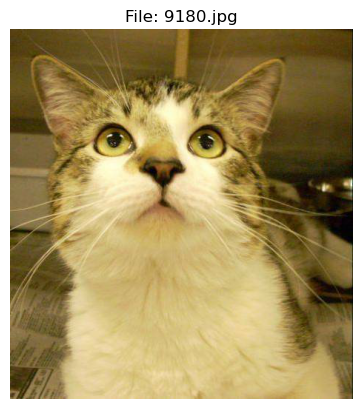

NameError: name 'labels' is not defined

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

for file in os.listdir("data/test"):
    if not file.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join("data/test", file)
    img = Image.open(img_path)

    # Show the image
    plt.imshow(img)
    plt.title(f"File: {file}")
    plt.axis('off')
    plt.show()

    # Apply transforms and predict
    img_t = transform_pipeline(img).to(device)
    img_t = torch.unsqueeze(img_t, 0)

    prediction = F.softmax(simplenet(img_t), dim=1)
    predicted_class = labels[prediction.argmax()]

    print(f"Predicted: {predicted_class}")